In [1]:
import scipy.stats as st
import numpy as np
import seaborn as sns
import h5py
from numba import njit

## define a continuous pdf to sample from.

In [2]:
class my_pdf(st.rv_continuous):
    def _pdf(self,x):
        return (1+np.cos(12.58*x))  # Normalized over its range, in this case [0,1]

my_cv = my_pdf(a=0, b=2, name='my_pdf')

### This wasn't really necessary, but I tuned it to range basically from 0 to 1 so that we didn't have to normalize our draws:

In [3]:
_max = np.max(my_cv.rvs(size=10000))
_max

0.9994398252847675

## You can see the shape of the sampling:

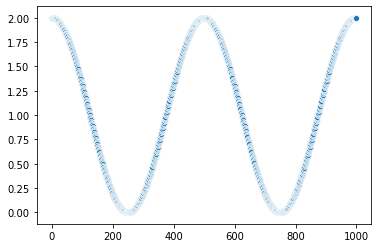

In [4]:
sns.scatterplot(range(1000), 1+1*np.cos(12.58*np.linspace(0,1,num=1000)+0) );

## so we have really high recombination rates at the ends and right in the middle.

## Now let's make an array of gametes!

In [5]:
gams = h5py.File("gams.hdf5",'w')

In [6]:
num_gams = int(1e5)

In [7]:
gams.create_dataset("start_haplo",
                    data=np.random.binomial(1,.5,size=num_gams),
                    dtype=np.int8)

<HDF5 dataset "start_haplo": shape (100000,), type "|i1">

In [8]:
gams.create_dataset("num_crossovers",
                    data=1+np.random.binomial(1,.2,size=num_gams),
                    dtype=np.int8)

<HDF5 dataset "num_crossovers": shape (100000,), type "|i1">

In [9]:
np.sum(gams["num_crossovers"])

120151

In [10]:
gams.create_dataset("crossovers",
                    data = np.vstack([np.hstack([np.repeat(i,gams['num_crossovers'][i]) for i in range(num_gams)]),
                                      my_cv.rvs(size=np.sum(gams["num_crossovers"]))]).T)

<HDF5 dataset "crossovers": shape (120151, 2), type "<f8">

In [11]:
gams.close()

## a single human cell contains 6pg of DNA
## a 1GB genome then contains 6/3.2 = 1.875pg DNA
## a sequencing machine needs from 1ng to 1ug of DNA.
## so 1000 cells of 1GB can give us 1.875ng of DNA, enough to sequence.

## But for library prep, we need at MINIMUM 100ng for a sample -- that is, 5uL at 20ng/uL concentration.

## ...so we need more like 100,000 cells PER ALIQUOT. (Precisely minimum 53,334)

### make our aliquots:

In [3]:
gams = h5py.File("gams.hdf5",'r')

In [2]:
# num gams per aliquot
gpa = 10
# num aliquots
nali = 500

In [5]:
samp_arr = np.random.choice(range(gams['num_crossovers'].shape[0]),
                 size=gpa*nali,
                 replace=False).reshape((nali,gpa))

In [7]:
with h5py.File("samp_arr.hdf5","w") as f:
    f.create_dataset("samp_arr",
                    data=samp_arr,
                    dtype=np.int64)

In [8]:
gams.close()

In [7]:
# number of cut sites per genome (we can assign specific locations later)
ncutsites = 100

In [10]:
samp_arr

array([[97892,  6245, 51129, ..., 14955, 60620, 68870],
       [ 6934, 13632, 78333, ..., 58225, 10889, 82330],
       [42235, 30162, 79550, ..., 24793, 50178,  8600],
       ...,
       [74012, 96437, 45510, ..., 47867, 46656, 79855],
       [31516, 10251, 16717, ..., 99693, 20426, 73409],
       [ 1287, 39832, 44982, ..., 96152, 27987, 16702]])

### make some sequencing functions...

In [11]:
@njit
def get_read(arr,
             ncutsites,
            ):
    '''
    arr is shape aliquots x gamete indexes
    this fuction returns the aliquot number, the gamete index, and the cut site index (from 0 to `ncutsites`)
    '''
    alinum = np.random.randint(arr.shape[0])
    colnum = np.random.randint(arr.shape[1])
    gamidx = samp_arr[alinum,colnum]
    cutsiteidx = np.random.randint(ncutsites)
    return(alinum, gamidx, cutsiteidx)

In [12]:
@njit
def do_sequencing(arr,
                  ncutsites,
                  num_reads,
                 ):
    seqarr = np.zeros((num_reads,3),dtype=np.int64)
    for rowidx in range(num_reads):
        seqarr[rowidx] = get_read(arr,ncutsites)
    return(seqarr)

### sequencing time!

In [3]:
samp_arr_file = h5py.File("samp_arr.hdf5","r")

In [6]:
samp_arr = samp_arr_file['samp_arr']

In [13]:
num_reads = int(1e7)

In [14]:
with h5py.File("seqs.hdf5",'w') as f:
    f.create_dataset("seqarr",
                    data=do_sequencing(samp_arr,ncutsites,num_reads),
                    dtype=np.int64)

In [15]:
seqh5 = h5py.File("seqs.hdf5",'r')

### "demultiplex" and "align" the sequences into an hdf5 file with aliquots at the surface level and locus # at the next level down.

In [275]:
seqs_reshape = h5py.File('seqs_reshape.hdf5','w')
for alinum in range(nali):
    tmpgroup = seqs_reshape.create_group(str(alinum))
    for locusnum in range(ncutsites):
        alisamp = np.take(seqh5['seqarr'],np.where(seqh5['seqarr'][:,0] == alinum),axis=0)[0]
        gams_seqed = np.take(alisamp,np.where(alisamp[:,2] == locusnum),axis=0)[0][:,1]
        
        tmpgroup.create_dataset(str(locusnum),
                          dtype=np.int64,
                          data = gams_seqed)

In [276]:
seqs_reshape.close()

### now assign each read to a haplotype!

### this is the main bottleneck for the whole code process...

In [8]:
gams = h5py.File("gams.hdf5",'r')

In [9]:
crossarr = gams['crossovers']
haplostart = gams['start_haplo']

In [10]:
seqs_reshape = h5py.File('seqs_reshape.hdf5','r')

In [14]:
haplotypes = h5py.File('haplotypes.hdf5','w')

In [15]:
@njit
def convert_haplo(n,s):
    s_ = s
    for i in range(n):
        s_ = 1-s_
    return(s_)

In [16]:
for ali_idx_ in range(500):
    tmpgroup = haplotypes.create_group(str(ali_idx_))
    for locus_idx_ in range(ncutsites):
        
        readidxs = seqs_reshape[str(ali_idx_)][str(locus_idx_)]
        readloc = locus_idx_ / ncutsites
        haplos = []
        for readidx in readidxs:
            crosses = np.take(crossarr[:,1],np.where(crossarr[:,0] == readidx))[0]
            #crosses = crossarr[crossarr[:,0] == readidx,1]
            starter = np.take(haplostart,
                              readidx)
            
            passes = np.sum(readloc > crosses)
            #read_haplo = starter
            #for i in range(passes):
            #    read_haplo = 1-read_haplo
            
            haplos.append(convert_haplo(passes,starter))
        
        tmpgroup.create_dataset(str(locus_idx_),
                          dtype=np.int64,
                          data = haplos)
    print(ali_idx_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
haplotypes.close()

### now compare!

In [19]:
haplotypes = h5py.File('haplotypes.hdf5','r')

In [22]:
np.mean(haplotypes['10']['15'])

0.5897435897435898

In [24]:
ali_mean_arr = np.zeros((nali,ncutsites))
for ali_idx_ in range(500):
    #currgam_arr = np.take(seqh5['seqarr'][:,1:],np.where(seqh5['seqarr'][:,0] == ali_idx_),axis=0)[0]
    ali_means = np.zeros((ncutsites))
    for locus_idx_ in range(ncutsites):
        #readidxs = seqh5['seqarr'][np.alltrue(
        #    np.array(seqh5['seqarr'])[:,[0,2]] == [ali_idx_,locus_idx_],
        #             axis=1),
        #                           1]
        haps = haplotypes[str(ali_idx_)][str(locus_idx_)]

        ali_means[locus_idx_] = np.mean(haps)
    ali_mean_arr[ali_idx_,:] = ali_means
    print(ali_idx_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
var_norm_dists = np.zeros((500,ali_mean_arr.shape[1]-1))
for rowidx in range(500):
    for colidx in range(ali_mean_arr.shape[1]-1):
        var_norm_dists[rowidx,colidx] = (np.abs(ali_mean_arr[rowidx][colidx]-ali_mean_arr[rowidx][colidx+1])/np.var(ali_mean_arr[rowidx]))

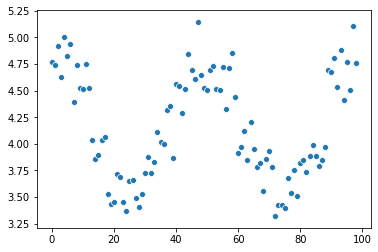

In [26]:
# 500 rows
sns.scatterplot(range(99),np.mean(var_norm_dists,axis=0))